## MODELING

In [1]:
# !pip install xgboost
# !pip install lightgbm


From the previous notebooks we confirmed that there is skewness in our data that needs our attention. We will generate random sampling methods, the idea is we create two over sampling methods and one under sampling method. Then we create models using those sampling methods, so for each model we can expect three. 

Throughout this notebook, we can expect a few things to see when a model is built. AUC-ROC score followed by the ROC curve, and then we will make sense of confusion matrix and classification reports for each model. 

Our clients want us to have a model that tells us how many we correctly identified as having a heart disease. 

we would like to completely avoid any situations where the patient has heart disease, but our model classifies as him not having it i.e., aim for high recall.

Thus, the measure we will use to evaluate our models will be Recall. Recall is the fraction of the total amount of relevant instances that were actually retrieved, in simple terms, what percentage of actual positive predictions were correctly classified by the classifier. 

First we will import the modules, confirm that there is skewness in our target variable and go on about making sampling methods. 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version

from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

from sklearn.decomposition import PCA

#Standardize a dataset along any axis. Center to the mean and component wise scale to unit variance.
from sklearn.preprocessing import scale


from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Construct a Pipeline from the given estimators.
from sklearn.pipeline import make_pipeline


from sklearn.feature_selection import SelectKBest, f_regression
import datetime


In [3]:
hearts = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Capstone 2\\Personal Key Indicators of Heart Disease\\heart_2020_cleaned.csv")

In [4]:
hearts['HeartDisease'].value_counts(normalize = True)

No     0.914405
Yes    0.085595
Name: HeartDisease, dtype: float64

In [5]:
X_train = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\X_train.csv")
X_test = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\X_test.csv")
y_train = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\y_train.csv")
y_test = pd.read_csv("C:\\Users\\hanna\\OneDrive\\Desktop\\All Folders\\Data Science\\SpringBoard\\Guided Capstone 2\\worked on excels\\y_test.csv")


In [6]:
print("\n")
print("X_train:", type(X_train), X_train.shape) 

# AJS:
print("\n")
print("X_test", type(X_test), X_test.shape) 

print("\n")
print("y_train", type(y_train), y_train.shape) 

print("\n")
print("y_test", type(y_test), y_test.shape) 




X_train: <class 'pandas.core.frame.DataFrame'> (239846, 50)


X_test <class 'pandas.core.frame.DataFrame'> (79949, 50)


y_train <class 'pandas.core.frame.DataFrame'> (239846, 1)


y_test <class 'pandas.core.frame.DataFrame'> (79949, 1)


We need to convert y_train & y_test into series instead of a DataFrame.

In [7]:
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [8]:
print("\n")
print("y_train", type(y_train), y_train.shape, len(y_train)) 

print("\n")
print("y_test", type(y_test), y_test.shape, len(y_test)) 



y_train <class 'pandas.core.series.Series'> (239846,) 239846


y_test <class 'pandas.core.series.Series'> (79949,) 79949


In [9]:
y_train.value_counts(normalize = True), y_test.value_counts(normalize = True)

(0    0.914403
 1    0.085597
 Name: HeartDisease, dtype: float64,
 0    0.914408
 1    0.085592
 Name: HeartDisease, dtype: float64)

Our y_train and y_test set are as skewed as our target varible. 

What we want to do is take the skewness off, build models using the data with no skewness and then test those models again on the skewed data. Such a problem that there is no skewness is very unlikely in the real data, hence why we want to preserve our test set, so we can apply our models to a real world like set.

### Over Sampling

#### Smote on training set

In [10]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 10)
X_smote, y_smote = smote.fit_resample(X_train, y_train)


In [11]:
X_smote.shape, y_smote.shape


((438632, 50), (438632,))

In [12]:
y_smote.value_counts(normalize = True)

0    0.5
1    0.5
Name: HeartDisease, dtype: float64

#### ADASYN

In [13]:
from imblearn.over_sampling import ADASYN

X_adasyn, y_adasyn = ADASYN().fit_resample(X_train, y_train)

In [14]:
X_adasyn.shape, y_adasyn.shape

((441820, 50), (441820,))

In [15]:
y_adasyn.value_counts(normalize = True)

1    0.503608
0    0.496392
Name: HeartDisease, dtype: float64

In [16]:
# X_train_adasyn, X_test_adasyn, y_train_adasyn, y_test_adasyn = train_test_split(X_adasyn, y_adasyn, random_state=5)

In [17]:
# X_train_adasyn.shape, y_train_adasyn.shape, X_test_adasyn.shape, y_test_adasyn.shape

### Under Sampling

#### Random Under Sampler

In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_rus, y_rus, = rus.fit_resample(X_train, y_train)

X_rus.shape, y_rus.shape

((41060, 50), (41060,))

In [19]:
y_rus.value_counts(normalize = True)

0    0.5
1    0.5
Name: HeartDisease, dtype: float64

After applying sampling method, The skewness is off and the count has been even to a 50/50 rather than a 92/8.

Our first model will be Random Forest, we will search for the best parameters using RandomizedSearchCV and then use those parameters to generate a model 

### Random Forest

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

In [21]:
rf = RandomForestClassifier()

In [22]:
rf_param_grid = {
                 'max_depth' : [4, 6, 8,10],
                 'n_estimators': range(1,10),
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10,20],
                 'min_samples_leaf': [1, 3, 10,18],
                 'bootstrap': [True, False],
                 
                 }

In [23]:
m_r = RandomizedSearchCV(param_distributions = rf_param_grid, 
                                    estimator = rf, scoring = "f1", 
                                    verbose = 0, n_iter = 100, cv = 5)

##### Random Forest - RUS

In [24]:
%time m_r.fit(X_rus, y_rus)

Wall time: 1min


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 10, 18],
                                        'min_samples_split': [2, 3, 10, 20],
                                        'n_estimators': range(1, 10)},
                   scoring='f1')

In [25]:
m_r.best_score_

0.7463110943235193

In [26]:
m_r.best_params_

{'n_estimators': 8,
 'min_samples_split': 3,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': False}

In [27]:
rf_bp = m_r.best_params_

In [28]:
rf_classifier = RandomForestClassifier(n_estimators = rf_bp["n_estimators"],
                                     min_samples_split = rf_bp['min_samples_split'],
                                     min_samples_leaf = rf_bp['min_samples_leaf'],
                                     max_features = rf_bp['max_features'],
                                     max_depth = rf_bp['max_depth'],
                                     bootstrap = rf_bp['bootstrap'])

In [29]:
rf_classifier.fit(X_rus, y_rus)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='log2',
                       min_samples_leaf=10, min_samples_split=3,
                       n_estimators=8)

In [30]:
y_test_pred_rf_rus = rf_classifier.predict(X_test)
print(accuracy_score(y_test_pred_rf_rus, y_test))

0.7436740922337991



 AUC-ROC: 0.741226185855919


Text(0.5, 0, 'False Positive Rate')

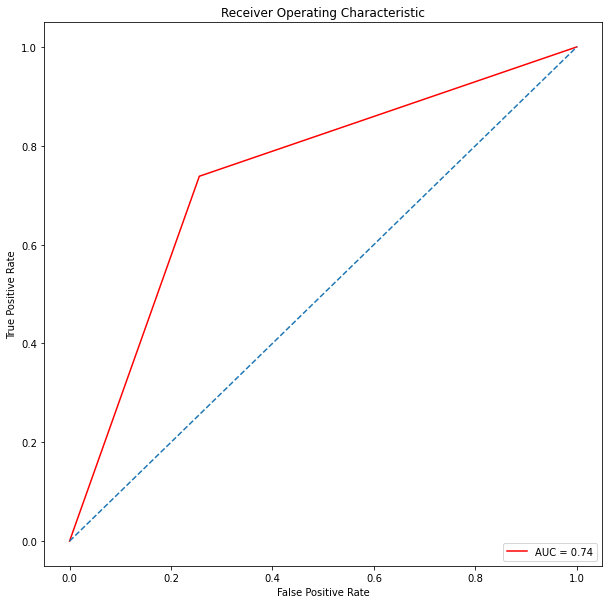

In [31]:
from sklearn import metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_test, y_test_pred_rf_rus))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_rf_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

The area under the curve is 0.76, which is significantly better than 0.55 which was generate from a basic logistic regression model.

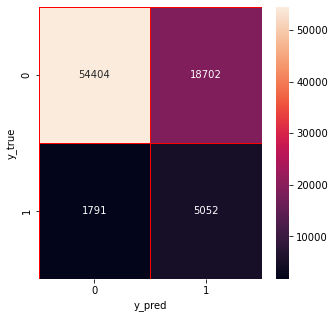

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84     73106
           1       0.21      0.74      0.33      6843

    accuracy                           0.74     79949
   macro avg       0.59      0.74      0.59     79949
weighted avg       0.90      0.74      0.80     79949



In [120]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_rf_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rf_rus))

This classification matrix is a good start, however if we dive into classification report, it will be much more helpful.

- Precision is a measure of how many of the positive predictions made are correct (true positives)
- Recall: over all the positive cases in the data, how many of the positive cases the classifier correctly predicted.
- F1-Score is a measure combining both precision and recall.

This classification report tells us that we will be 74% (0.74 recall for 1) correct in identifying the relevant target variable which is 1.

##### Random Forest - ADASYN

In [34]:
%time m_r.fit(X_adasyn, y_adasyn)

Wall time: 15min 51s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 10, 18],
                                        'min_samples_split': [2, 3, 10, 20],
                                        'n_estimators': range(1, 10)},
                   scoring='f1')

In [35]:
m_r.best_score_

0.8318556814948155

In [36]:
m_r.best_params_

{'n_estimators': 6,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [37]:
rf_bp = m_r.best_params_

In [38]:
rf_classifier = RandomForestClassifier(n_estimators = rf_bp["n_estimators"],
                                     min_samples_split = rf_bp['min_samples_split'],
                                     min_samples_leaf = rf_bp['min_samples_leaf'],
                                     max_features = rf_bp['max_features'],
                                     max_depth = rf_bp['max_depth'],
                                     bootstrap = rf_bp['bootstrap'])

In [39]:
rf_classifier.fit(X_adasyn, y_adasyn)

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=3, n_estimators=6)

In [40]:
y_test_pred_rf_adasyn = rf_classifier.predict(X_test)
print(accuracy_score(y_test_pred_rf_adasyn, y_test))

0.7966953933132372



 AUC-ROC: 0.7253157609521325


Text(0.5, 0, 'False Positive Rate')

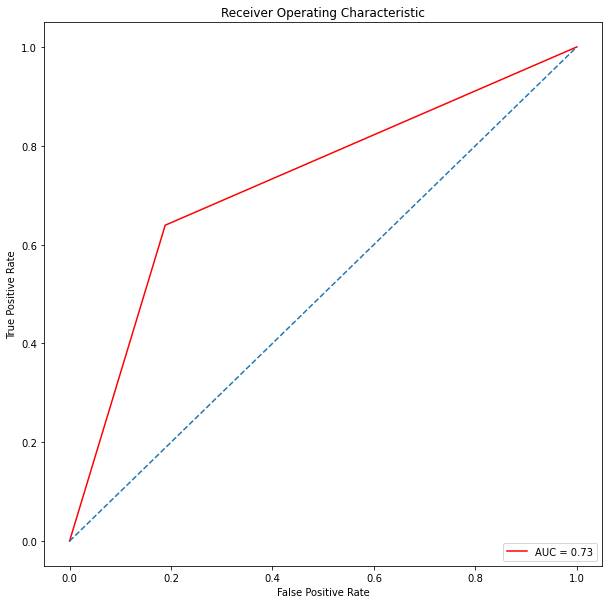

In [41]:
from sklearn import metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_test, y_test_pred_rf_adasyn))


from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_rf_adasyn)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

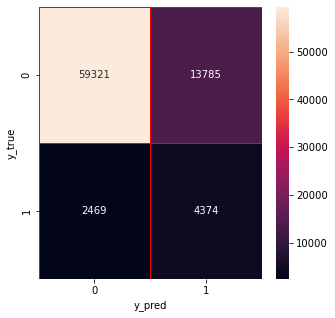

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.96      0.81      0.88     73106
           1       0.24      0.64      0.35      6843

    accuracy                           0.80     79949
   macro avg       0.60      0.73      0.61     79949
weighted avg       0.90      0.80      0.83     79949



In [121]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_rf_adasyn)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rf_adasyn))

Our target variable recall for class 1 has decreased from 0.74 to 0.60, in that way our under sampling model did better than over sampling, let us see if that stays the same with smote.

##### Random Forest - SMOTE

In [44]:
%time m_r.fit(X_smote, y_smote)

Wall time: 17min 34s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [4, 6, 8, 10],
                                        'max_features': ['sqrt', 'auto',
                                                         'log2'],
                                        'min_samples_leaf': [1, 3, 10, 18],
                                        'min_samples_split': [2, 3, 10, 20],
                                        'n_estimators': range(1, 10)},
                   scoring='f1')

In [45]:
m_r.best_score_

0.8310874336635612

In [46]:
m_r.best_params_

{'n_estimators': 8,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [47]:
rf_bp = m_r.best_params_

In [48]:
rf_classifier = RandomForestClassifier(n_estimators = rf_bp["n_estimators"],
                                     min_samples_split = rf_bp['min_samples_split'],
                                     min_samples_leaf = rf_bp['min_samples_leaf'],
                                     max_features = rf_bp['max_features'],
                                     max_depth = rf_bp['max_depth'],
                                     bootstrap = rf_bp['bootstrap'])

In [49]:
rf_classifier.fit(X_smote, y_smote)

RandomForestClassifier(bootstrap=False, max_depth=10, max_features='sqrt',
                       min_samples_split=10, n_estimators=8)

In [50]:
y_test_pred_rf_smote = rf_classifier.predict(X_test)
print(accuracy_score(y_test_pred_rf_smote, y_test))

0.8196225093497105



 AUC-ROC: 0.7146063292000506


Text(0.5, 0, 'False Positive Rate')

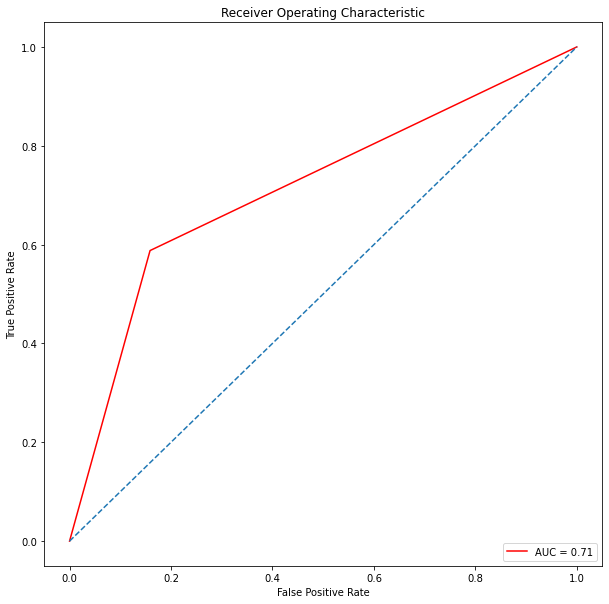

In [51]:
from sklearn import metrics
print("\n AUC-ROC:", metrics.roc_auc_score(y_test, y_test_pred_rf_smote))

from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_rf_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


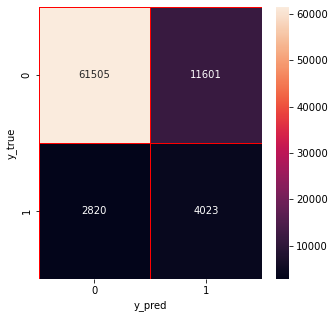

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     73106
           1       0.26      0.59      0.36      6843

    accuracy                           0.82     79949
   macro avg       0.61      0.71      0.63     79949
weighted avg       0.90      0.82      0.85     79949



In [122]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_rf_smote)

f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rf_smote))

The Adasyn & Smote over sampling method are doing worse than RUS (Random Under Sampler) method for RF. The Roc_Auc more or less the same for all three, but the recall measure for our target variable class is 0.74 for RUS method, whereas 0.60 & 0.59 for ADASYN and SMOTE respectively.

### XGBoost

Again we will create a model and using RandomizedSearchCV to find the optimal parameters to run the model with. 

In [54]:
import xgboost as xgb

xb = xgb.XGBClassifier()

In [55]:
xb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [56]:
xb_param_grid = {
                 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
                 "max_depth"        : [ 3, 5, 6, 8],
                 "min_child_weight" : [ 1, 3, 5, 7],
                 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
                 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
    }

In [57]:
xg_r = RandomizedSearchCV(param_distributions = xb_param_grid, 
                                    estimator = xb, scoring = "f1", 
                                    verbose = 0, n_iter = 10, cv = 5)


##### XGBoost - ADASYN

In [58]:
%time xg_r.fit(X_adasyn, y_adasyn)

Wall time: 18min 9s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [59]:
xg_r.best_score_

0.9128626608863293

In [60]:
xg_bp = xg_r.best_params_
xg_bp

{'min_child_weight': 3,
 'max_depth': 8,
 'learning_rate': 0.25,
 'gamma': 0.0,
 'colsample_bytree': 0.3}

In [61]:
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

In [62]:
xg_classifier.fit(X_adasyn, y_adasyn)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [63]:
y_test_pred_xg_adasyn = xg_classifier.predict(X_test)
print(accuracy_score(y_test_pred_xg_adasyn, y_test))

0.8979349335201191


Text(0.5, 0, 'False Positive Rate')

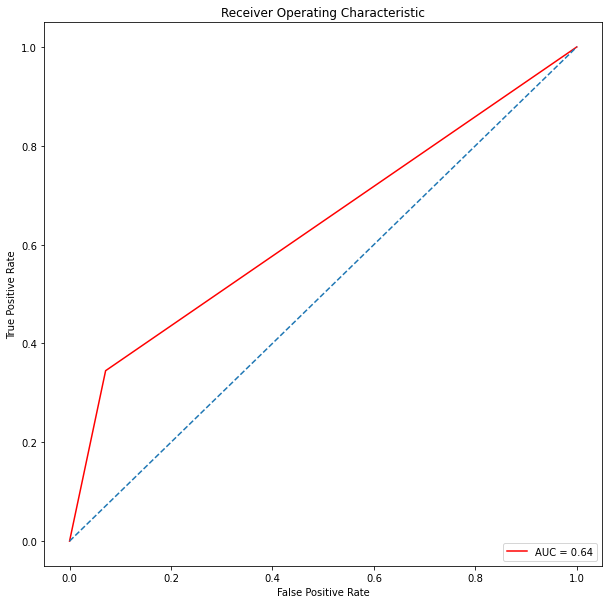

In [64]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_pred_xg_adasyn, y_test)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

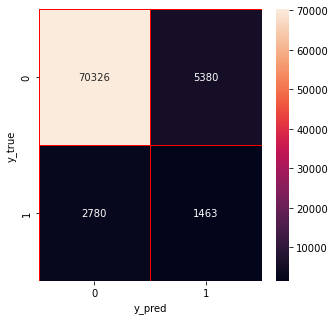

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.96      0.95     73106
           1       0.34      0.21      0.26      6843

    accuracy                           0.90     79949
   macro avg       0.64      0.59      0.60     79949
weighted avg       0.88      0.90      0.89     79949



In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_pred_xg_adasyn, y_test)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xg_adasyn))

The oversampling technique with XGBoost has done the worst by far in recall score for the target class with 0.19.

##### XGBoost - SMOTE

In [67]:
%time xg_r.fit(X_smote, y_smote)

Wall time: 16min 51s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [68]:
xg_r.best_score_

0.9159484059432984

In [69]:
xg_bp = xg_r.best_params_
xg_bp

{'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.3,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [70]:
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

In [71]:
xg_classifier.fit(X_smote, y_smote)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [72]:
y_test_pred_xg_smote = xg_classifier.predict(X_test)
print(accuracy_score(y_test_pred_xg_smote, y_test))

0.9013746263242818


Text(0.5, 0, 'False Positive Rate')

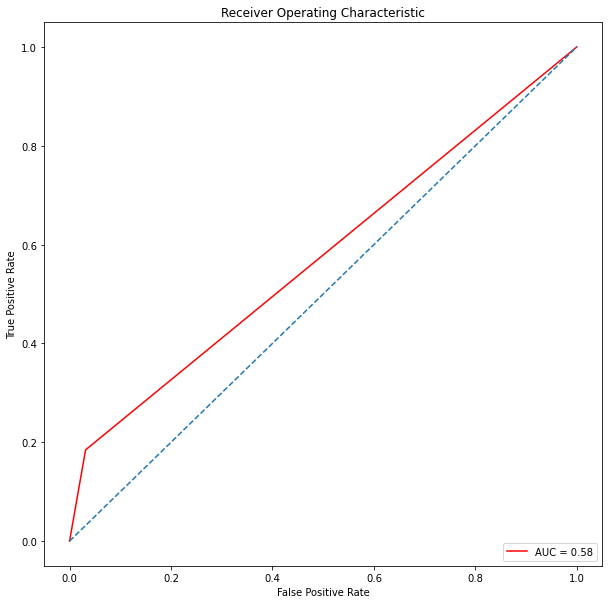

In [73]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_xg_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

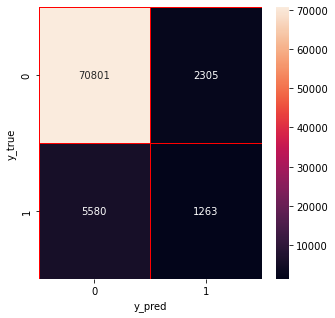

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     73106
           1       0.35      0.18      0.24      6843

    accuracy                           0.90     79949
   macro avg       0.64      0.58      0.59     79949
weighted avg       0.88      0.90      0.89     79949



In [124]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_xg_smote)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xg_smote))


Again, we see that oversampling method is leading us to a low recall score which we are trying to avoid.

##### XGBoost - RUS

In [76]:
%time xg_r.fit(X_rus, y_rus)

Wall time: 1min 13s


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           min_child_weight=None, missing=nan,
                                           monotone_constra

In [77]:
xg_r.best_score_

0.7724259860555737

In [78]:
xg_bp = xg_r.best_params_
xg_bp

{'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

In [79]:
xg_classifier = xgb.XGBClassifier(learning_rate = xg_bp["learning_rate"],
                                     min_child_weight = xg_bp['min_child_weight'],
                                     max_depth = xg_bp['max_depth'],
                                     gamma = xg_bp['gamma'],
                                     colsample_bytree = xg_bp['colsample_bytree'])

In [80]:
xg_classifier.fit(X_rus, y_rus)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [81]:
y_test_pred_xg_rus = xg_classifier.predict(X_test)
print(accuracy_score(y_test_pred_xg_rus, y_test))

0.7401093196913032


Text(0.5, 0, 'False Positive Rate')

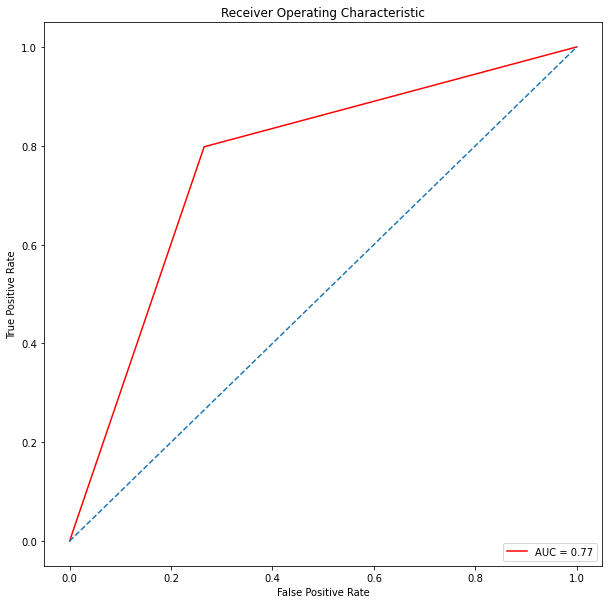

In [82]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_xg_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


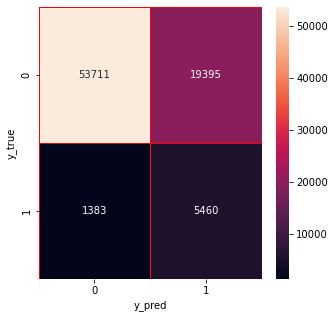

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.73      0.84     73106
           1       0.22      0.80      0.34      6843

    accuracy                           0.74     79949
   macro avg       0.60      0.77      0.59     79949
weighted avg       0.91      0.74      0.80     79949



In [125]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_xg_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xg_rus))


XGBoost with under sampling did the best by far in recall with 0.79, a 5 point jump from our previous best. We again see that undersampling provides us with low precision - high recall and oversampling does the opposite.

#### ADABoost_rus

Since ADABoost have two algorithms 'Samme' & 'Samme.R' we will generate 3 model for each algorithm and compare them.

In [85]:
from sklearn.ensemble import AdaBoostClassifier
ada_classifier_samme = AdaBoostClassifier(algorithm = 'SAMME', n_estimators = 1000)

In [86]:
%time ada_classifier_samme.fit(X_rus, y_rus)

Wall time: 37.9 s


AdaBoostClassifier(algorithm='SAMME', n_estimators=1000)

In [87]:
y_test_pred_ada_samme_rus = ada_classifier_samme.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_rus, y_test))

0.7590839159964478


Text(0.5, 0, 'False Positive Rate')

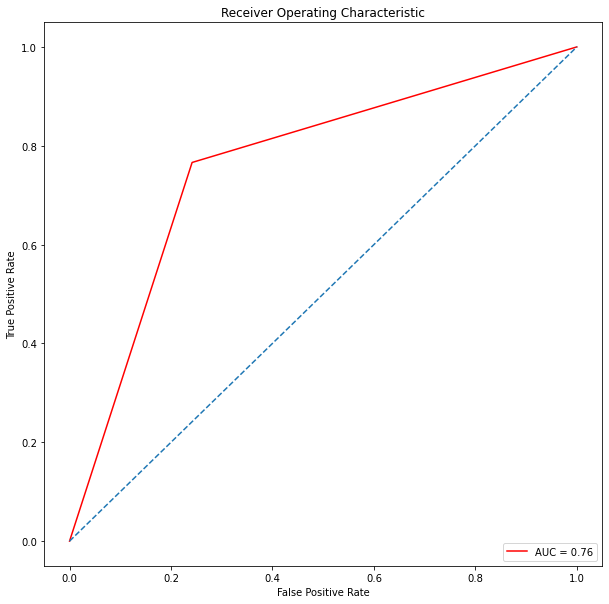

In [88]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

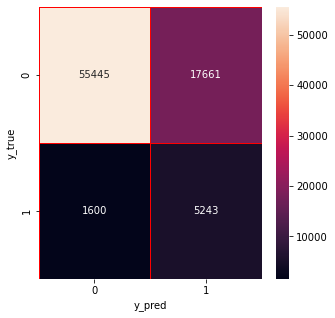

In [89]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [90]:
from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

y_train_pred_ada_samme_rus = ada_classifier_samme.predict(X_rus)

print("[Training Classification Report]")
print(classification_report(y_rus, y_train_pred_ada_samme_rus))

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_rus))


[Training Classification Report]
              precision    recall  f1-score   support

           0       0.77      0.75      0.76     20530
           1       0.76      0.77      0.76     20530

    accuracy                           0.76     41060
   macro avg       0.76      0.76      0.76     41060
weighted avg       0.76      0.76      0.76     41060

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.76      0.85     73106
           1       0.23      0.77      0.35      6843

    accuracy                           0.76     79949
   macro avg       0.60      0.76      0.60     79949
weighted avg       0.91      0.76      0.81     79949



##### ADABoost_adasyn - SAMME

In [91]:
%time ada_classifier_samme.fit(X_adasyn, y_adasyn)

Wall time: 9min 3s


AdaBoostClassifier(algorithm='SAMME', n_estimators=1000)

In [92]:
y_test_pred_ada_samme_adasyn = ada_classifier_samme.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_adasyn, y_test))

0.8740697194461469


Text(0.5, 0, 'False Positive Rate')

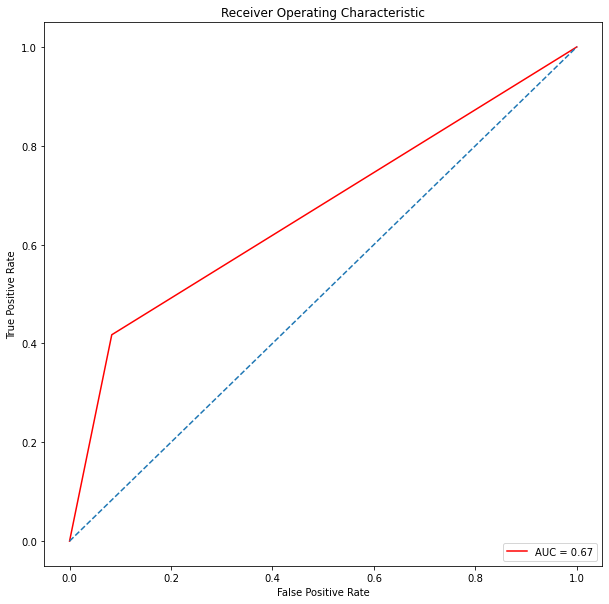

In [93]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_adasyn)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

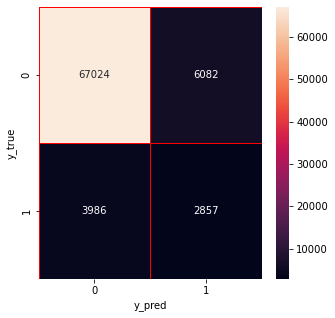

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     73106
           1       0.32      0.42      0.36      6843

    accuracy                           0.87     79949
   macro avg       0.63      0.67      0.65     79949
weighted avg       0.89      0.87      0.88     79949



In [126]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_adasyn)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_adasyn))

##### ADABoost_smote - SAMME


In [96]:
%time ada_classifier_samme.fit(X_smote, y_smote)

Wall time: 8min 59s


AdaBoostClassifier(algorithm='SAMME', n_estimators=1000)

In [97]:
y_test_pred_ada_samme_smote = ada_classifier_samme.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_smote, y_test))

0.8746701021901462


Text(0.5, 0, 'False Positive Rate')

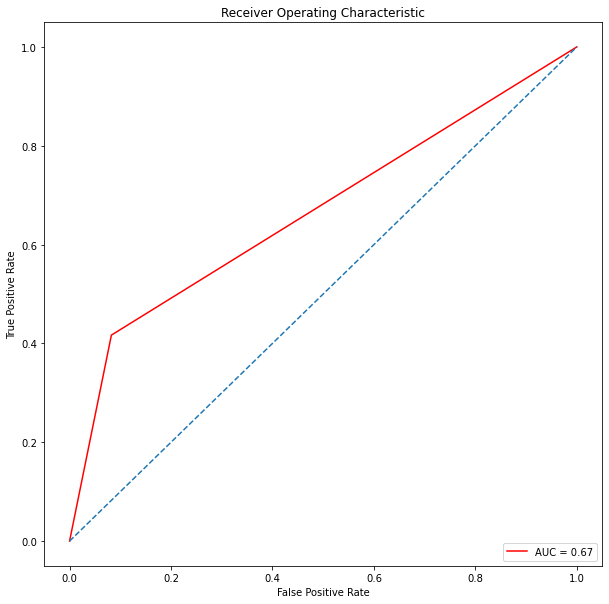

In [98]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

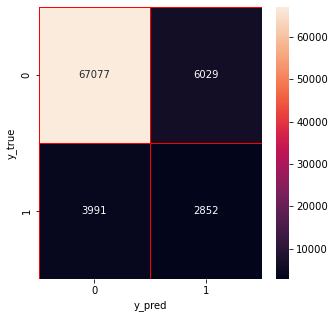

In [99]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_smote)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()


In [100]:
from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

y_train_pred_ada_samme_smote = ada_classifier_samme.predict(X_smote)

print("[Training Classification Report]")
print(classification_report(y_smote, y_train_pred_ada_samme_smote))

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_smote))


[Training Classification Report]
              precision    recall  f1-score   support

           0       0.90      0.92      0.91    219316
           1       0.92      0.90      0.91    219316

    accuracy                           0.91    438632
   macro avg       0.91      0.91      0.91    438632
weighted avg       0.91      0.91      0.91    438632

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     73106
           1       0.32      0.42      0.36      6843

    accuracy                           0.87     79949
   macro avg       0.63      0.67      0.65     79949
weighted avg       0.89      0.87      0.88     79949



We see the same pattern as before, our over sampling method is performing better than the under sampling method, with the number of correct predictions again over 90% and weighted f1 score 3 units below our best model which was XGBoost with ADASYN sampling method. 

##### ADABoost_rus - SAMME.R


In [101]:
ada_classifier_samme_r = AdaBoostClassifier(algorithm = 'SAMME.R', n_estimators = 1000)

In [102]:
%time ada_classifier_samme_r.fit(X_rus, y_rus)

Wall time: 41.9 s


AdaBoostClassifier(n_estimators=1000)

In [103]:
y_test_pred_ada_samme_r_rus = ada_classifier_samme_r.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_r_rus, y_test))

0.7557693029306183


Text(0.5, 0, 'False Positive Rate')

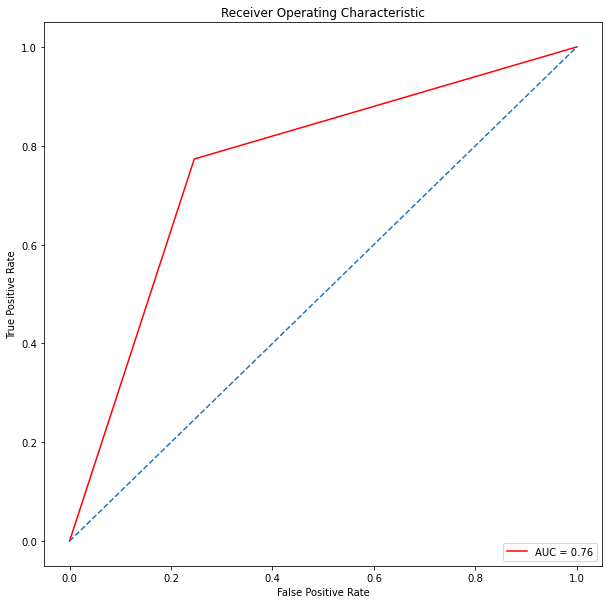

In [104]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_r_rus)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

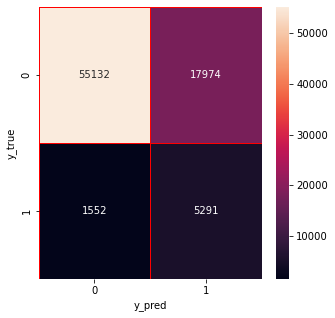

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85     73106
           1       0.23      0.77      0.35      6843

    accuracy                           0.76     79949
   macro avg       0.60      0.76      0.60     79949
weighted avg       0.91      0.76      0.81     79949



In [127]:

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_r_rus)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_r_rus))

##### ADABoost_adasyn - SAMME.R

In [108]:
%time ada_classifier_samme_r.fit(X_adasyn, y_adasyn)

Wall time: 9min 31s


AdaBoostClassifier(n_estimators=1000)

In [109]:
y_test_pred_ada_samme_r_adasyn = ada_classifier_samme_r.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_r_adasyn, y_test))

0.907115786313775


Text(0.5, 0, 'False Positive Rate')

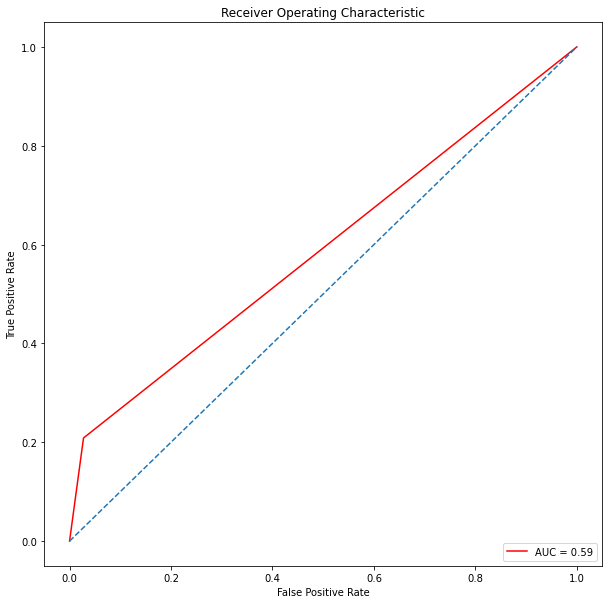

In [110]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_r_adasyn)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

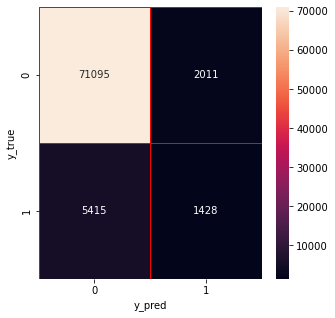

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     73106
           1       0.42      0.21      0.28      6843

    accuracy                           0.91     79949
   macro avg       0.67      0.59      0.61     79949
weighted avg       0.89      0.91      0.89     79949



In [128]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_r_adasyn)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_r_adasyn))

##### ADABoost_smote - SAMME.R


In [113]:
%time ada_classifier_samme_r.fit(X_smote, y_smote)

Wall time: 10min


AdaBoostClassifier(n_estimators=1000)

In [114]:
y_test_pred_ada_samme_r_smote = ada_classifier_samme_r.predict(X_test)
print(accuracy_score(y_test_pred_ada_samme_r_smote, y_test))

0.9059525447472764


Text(0.5, 0, 'False Positive Rate')

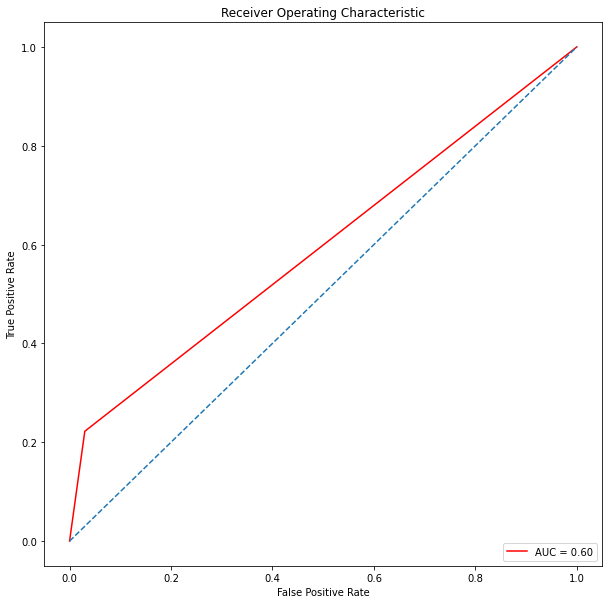

In [115]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_test_pred_ada_samme_r_smote)
roc_auc = auc(false_positive_rate, true_positive_rate)


import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

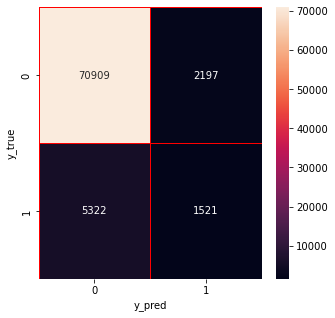

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     73106
           1       0.41      0.22      0.29      6843

    accuracy                           0.91     79949
   macro avg       0.67      0.60      0.62     79949
weighted avg       0.89      0.91      0.89     79949



In [129]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_ada_samme_r_smote)

f, ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot = True, linewidths = 0.5, linecolor = "red", fmt = ".0f",ax = ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_ada_samme_r_smote))

In [118]:
data = {
    'Model': ['Random Forest', 'Random Forest', 'Random Forest', 'XGBoost', 'XGBoost', 'XGBoost', 'ADABoost', 'ADABoost',  'ADABoost', 'ADABoost_SAMME.R', 'ADABoost_SAMME.R', 'ADABoost_SAMME.R'],
    'Sampling': ['RUS', 'ADASYN', 'SMOTE', 'RUS', 'ADASYN', 'SMOTE', 'RUS', 'ADASYN', 'SMOTE', 'RUS', 'ADASYN', 'SMOTE'],
    'Precision': [0.22, 0.25, 0.26, 0.22, 0.35, 0.36, 0.23, 0.32, 0.32, 0.23, 0.41, 0.41],
    'Recall': [0.74,0.60,0.59,0.79,0.19,0.19,0.77,0.42,0.42,0.77,0.21,0.22]}

df = pd.DataFrame(data)
df

,Model,Sampling,Precision,Recall
0,Random Forest,RUS,0.22,0.74
1,Random Forest,ADASYN,0.25,0.60
2,Random Forest,SMOTE,0.26,0.59
3,XGBoost,RUS,0.22,0.79
4,XGBoost,ADASYN,0.35,0.19
5,XGBoost,SMOTE,0.36,0.19
6,ADABoost,RUS,0.23,0.77
7,ADABoost,ADASYN,0.32,0.42
8,ADABoost,SMOTE,0.32,0.42
9,ADABoost_SAMME.R,RUS,0.23,0.77


In [119]:
df[df['Recall'] > 0.7]

,Model,Sampling,Precision,Recall
0,Random Forest,RUS,0.22,0.74
3,XGBoost,RUS,0.22,0.79
6,ADABoost,RUS,0.23,0.77
9,ADABoost_SAMME.R,RUS,0.23,0.77


We see that it is not possible to have a high precision and high recall score, there is a tradeoff. The under sampling method gives us high recall mainly because it is "under sampled" and, we correctly identified as having a heart disease (for less points), for all the patients who actually have heart disease, thus low precision high recall. On the other hand, with over sampling and having more data points, we achieve the high precision and low recall scenario, where our model will be more certain if a patient has heart disease or not. 

Our problem as stated by clients want to completely avoid any situations where the patient has heart disease, but our model classifies as him not having it.

XGBoost with the Random Under Sampler has the best recall with 0.79 for our target variable in test set.